In [1]:
!sudo add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!sudo apt-get update -qq 2>&1 > /dev/null
!sudo apt -y install -qq google-drive-ocamlfuse 2>&1 > /dev/null
!google-drive-ocamlfuse



debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin/xdg-open: 869: lynx: not found
/usr/bin/xdg-open: 869: w3m: not found
xdg-open: no method available for opening 'https://accounts.google.com/o/oauth2/auth?client_id=564921029129.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fgd-ocaml-auth.appspot.com%2Foauth2callback&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&

In [2]:
!sudo apt-get install -qq w3m # to act as web browser 
!xdg-settings set default-web-browser w3m.desktop # to set default browser
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package w3m.
(Reading database ... 122523 files and directories currently installed.)
Preparing to unpack .../w3m_0.5.3-37ubuntu0.1_amd64.deb ...
Unpacking w3m (0.5.3-37ubuntu0.1) ...
Setting up w3m (0.5.3-37ubuntu0.1) ...
Processing triggers for man-db (2.9.1-1) ...
Processing triggers for mime-support (3.64ubuntu1) ...
/content
/content/drive
/content
/
Access token retrieved correctly.


In [3]:
!pip install transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 85.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.3 MB/s eta 0:00:00


In [4]:
BASE_DIR = '/content/drive/MyDrive/Automatic Scene Description Generation/main/data'
WORKING_DIR = '/content/drive/MyDrive/Automatic Scene Description Generation/main'

In [5]:
from tqdm.notebook import tqdm
import os

In [6]:
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
import torch
from PIL import Image

model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



max_length = 16
num_beams = 4
gen_kwargs = {"max_length": max_length, "num_beams": num_beams}
def predict_step(image_paths):
  images = []
  for image_path in image_paths:
    i_image = Image.open(image_path)
    if i_image.mode != "RGB":
      i_image = i_image.convert(mode="RGB")

    images.append(i_image)

  pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
  pixel_values = pixel_values.to(device)
  #print(pixel_values)
  output_ids = model.generate(pixel_values, **gen_kwargs)
  #print(output_ids)
  preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
  preds = [pred.strip() for pred in preds]
  return preds

In [13]:
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
generate_caption('real_photo_2.jpg')

'a man with glasses is sitting on a bed'

In [14]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [15]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
len(mapping)

8091

In [16]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [ ]:
# before preprocess of text
mapping['1000268201_693b08cb0e']


['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [17]:
# preprocess the text
clean(mapping)

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.75)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = generate_caption_dataset(key) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/2023 [00:00<?, ?it/s]

BLEU-1: 0.419673
BLEU-2: 0.234512


In [ ]:
predicted

In [ ]:
!pip  install sacrebleu -q

!pip3 install datasets -q

import datasets
from datasets import load_metric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 17.4 MB/s eta 0:00:00


In [ ]:
bleu=load_metric("bleu")
#predictions=[["I",'have','30','years']]
predictions = predicted
references = actual
bleu.compute(predictions=predictions,references=references)

{'bleu': 0.07135596409273315,
 'precisions': [0.4196732639060264,
  0.13104507073143984,
  0.04181313598519889,
  0.011273957158962795],
 'brevity_penalty': 1.0,
 'length_ratio': 1.253154379020287,
 'translation_length': 20261,
 'reference_length': 16168}

In [22]:
def generate_caption_dataset(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name
    img_path=BASE_DIR + '/Images/' + image_name +'.jpg'
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
      print(caption)
    # predict the caption
    cap = predict_step([img_path])
    print('--------------------Predicted--------------------')
    print(cap[0])
    plt.imshow(image)


In [ ]:
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_path=BASE_DIR + '/test/' + image_name
    
    cap = predict_step([image_path])
    image = Image.open(image_path)
    plt.imshow(image)
    return(cap[0])

'a room filled with lots of tables and chairs'

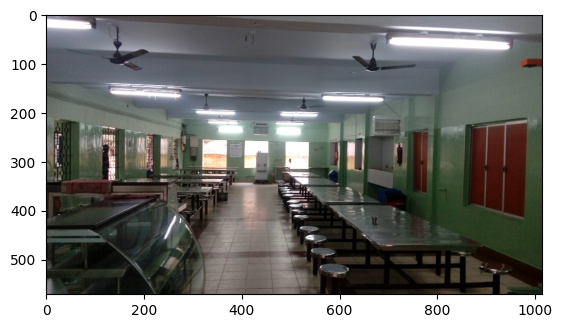

In [ ]:
generate_caption('canteen.png')

'a classroom filled with students and a teacher'

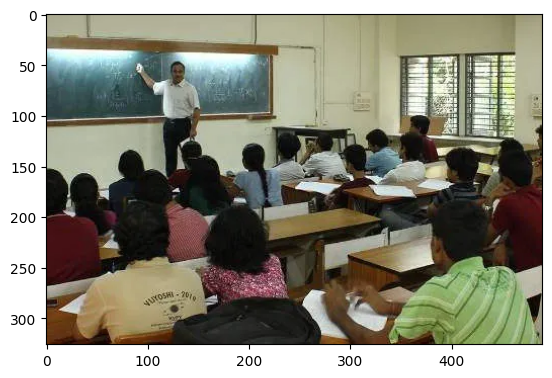

In [ ]:
generate_caption('teacher.webp')

'people sitting at a table with books'

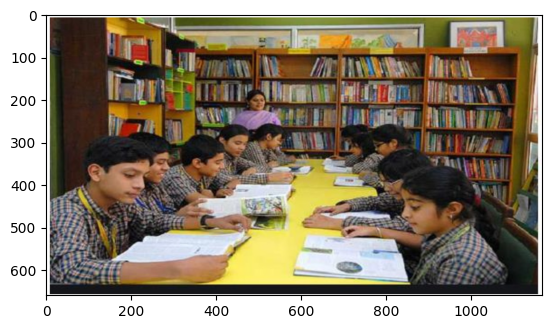

In [ ]:
generate_caption('students_reading.png')

'an old brick building with a fire hydrant in front of it'

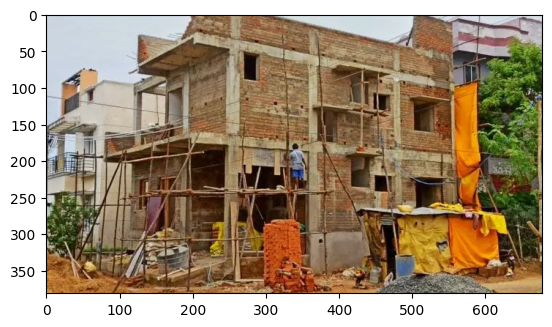

In [ ]:
generate_caption('construction.webp')

'a room with a television and a bed'

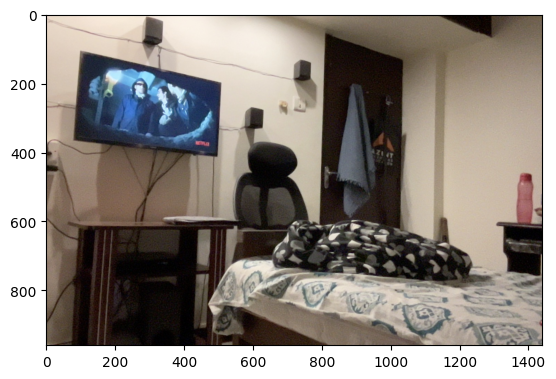

In [ ]:
generate_caption('real_photo_1.jpg')

'a black dog and a white dog are swimming in the water'

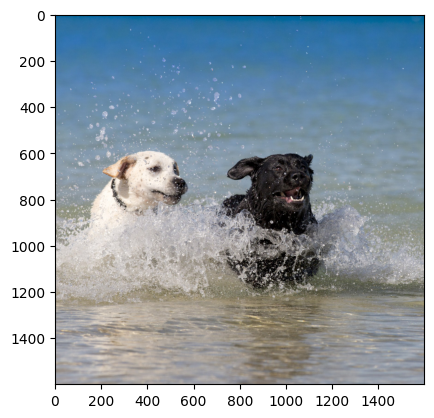

In [ ]:
generate_caption('tgw.jpg')

'a man on a skateboard in the middle of a crowd of people'

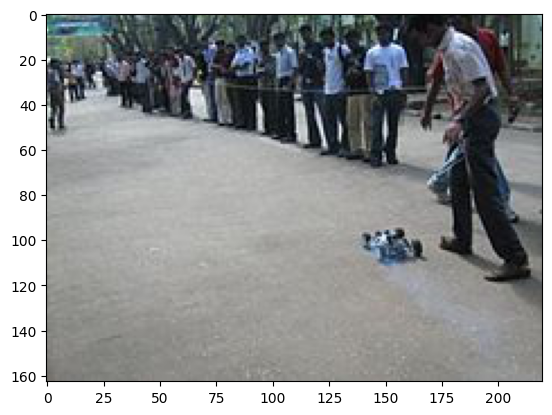

In [ ]:
generate_caption('students.jpg')

'a room full of people sitting in front of a television'

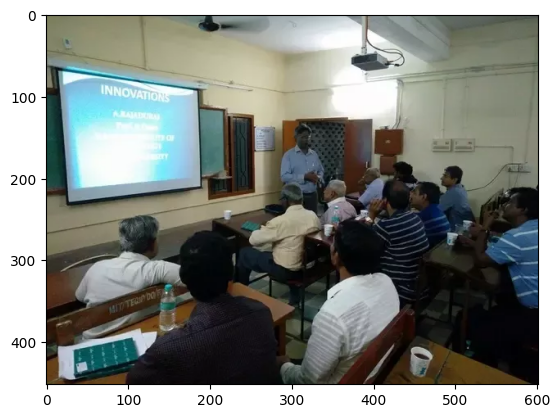

In [ ]:
generate_caption('lecture.webp')

'a road filled with trees and shrubs in the middle of a forest'

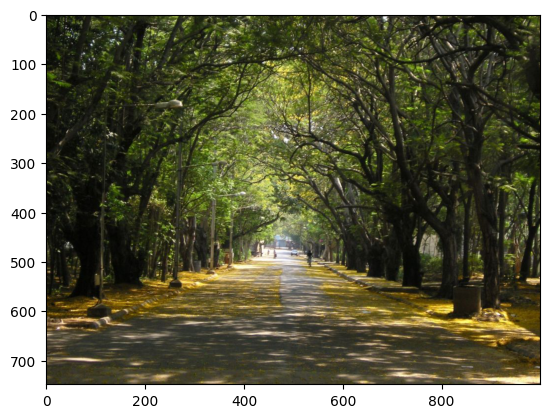

In [ ]:
generate_caption('mit_road.jpg')

'a man standing next to a stop sign'

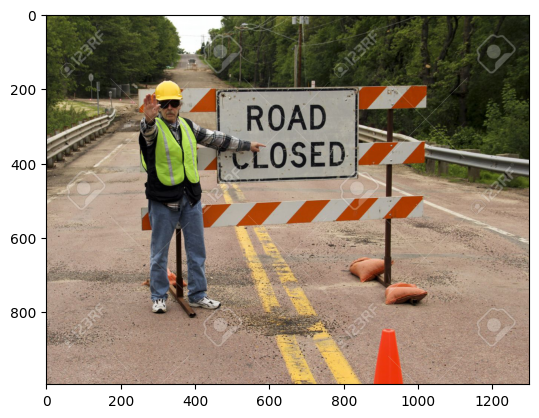

In [ ]:
generate_caption('road_closed.jpg')

'a construction crew working on a construction site'

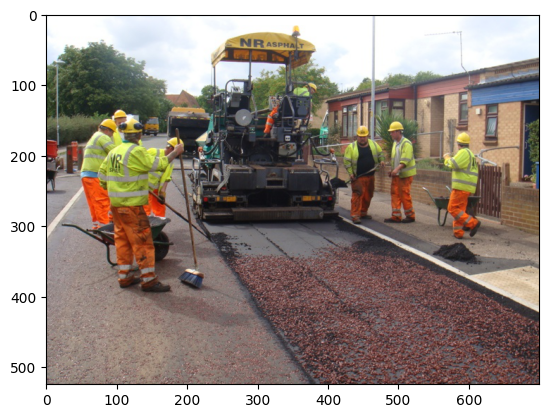

In [ ]:
generate_caption('road_construction.jpg')

'a small white dog standing on a dirt road'

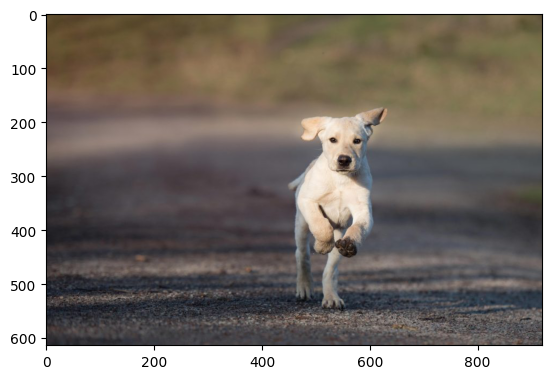

In [ ]:
generate_caption('dog_chasing.jpg')

'a restaurant with tables, chairs, and tables in it'

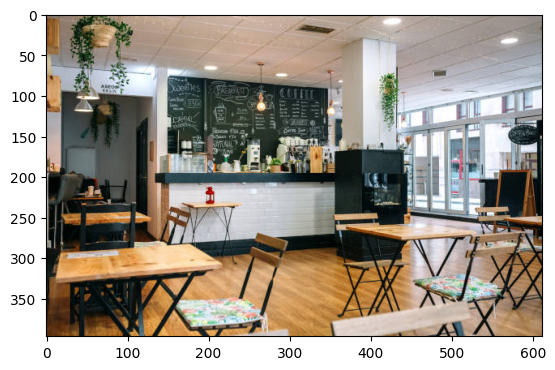

In [ ]:
generate_caption('coffeeshop.jpg')

'a woman crossing the street in front of a car'

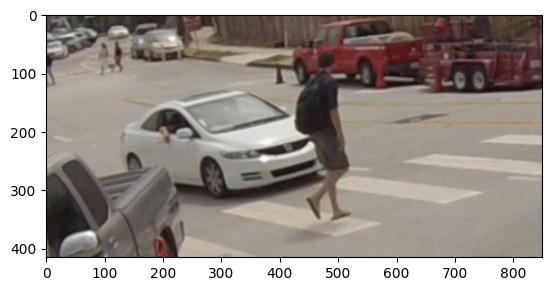

In [ ]:
generate_caption('speedingcar.jpg')

---------------------Actual---------------------
startseq man and woman are at catered dinner getting food endseq
startseq an asian couple dip their plates at buffet endseq
startseq young man and young woman serve food endseq
startseq girl and boy serving food on plate endseq
startseq two young people serve food endseq
--------------------Predicted--------------------
a woman and a man standing in front of a table with food


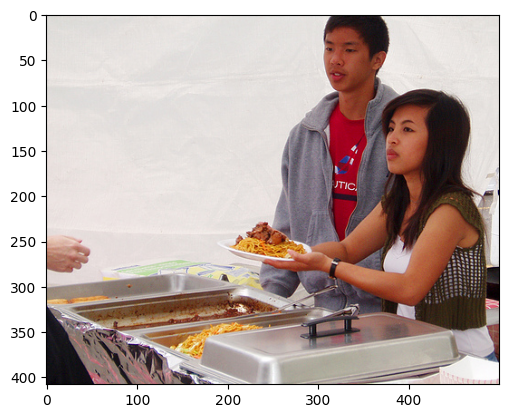

In [23]:
generate_caption_dataset('141755292_7a0b3364cf')

'a man with glasses sitting in a chair'

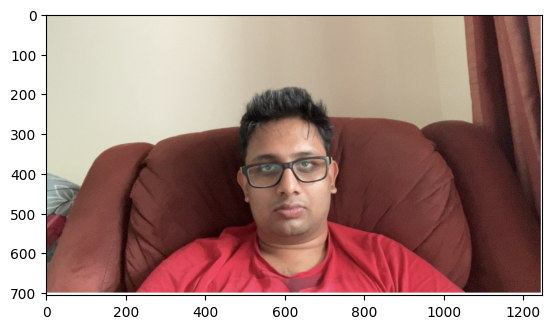

In [ ]:
generate_caption('real_photo_3.jpg')

---------------------Actual---------------------
startseq civil war reenactment with cannon teams firing cannons endseq
startseq group of men firing an old fashion cannon endseq
startseq recreation of some battle endseq
startseq sveral men participating in civil war reenactment endseq
startseq war reenactors fire cannon endseq
--------------------Predicted--------------------
a crowd of people standing around a fire hydrant


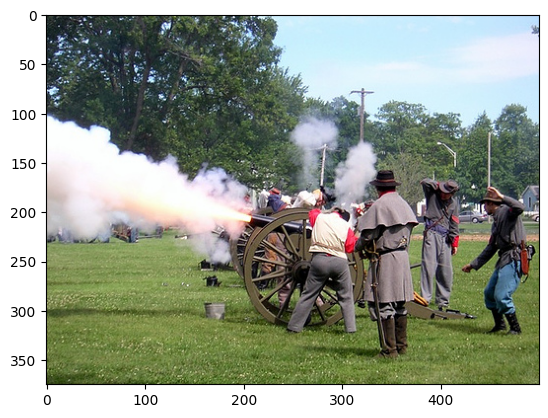

In [24]:
generate_caption_dataset('61209225_8512e1dad5')

---------------------Actual---------------------
startseq group of people are sitting around campfire at night endseq
startseq group of people sitting on the grass by fire at nighttime endseq
startseq group of young people are sitting around fire pit endseq
startseq friends enjoy campfire endseq
startseq several people sitting around campfire endseq
--------------------Predicted--------------------
a crowd of people standing around a fire hydrant


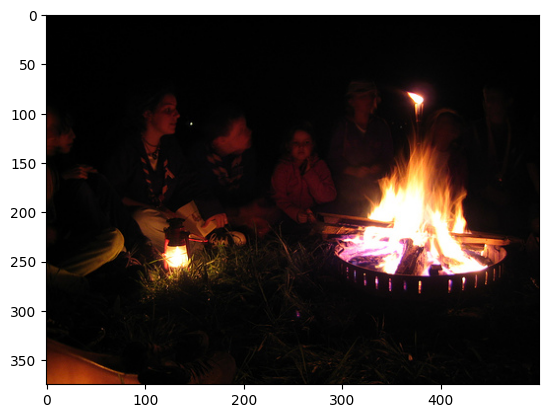

In [25]:
generate_caption_dataset('69710411_2cf537f61f')

---------------------Actual---------------------
startseq blonde horse and blonde girl in black sweatshirt are staring at fire in barrel endseq
startseq girl and her horse stand by fire endseq
startseq girl holding horse 's lead behind fire endseq
startseq "a man and girl and two horses are near contained fire ." endseq
startseq two people and two horses watching fire endseq
--------------------Predicted--------------------
a man standing next to a brown horse near a fire hydrant


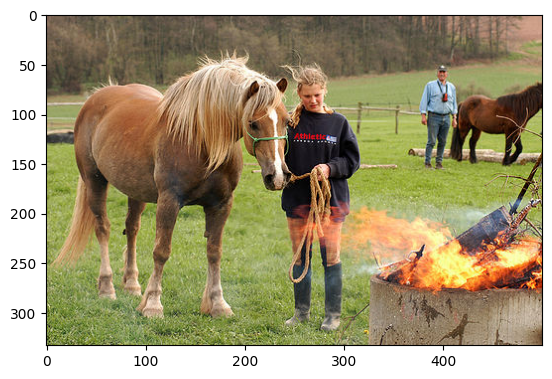

In [28]:
generate_caption_dataset('10815824_2997e03d76')

---------------------Actual---------------------
startseq woman is walking past an artificial waterfall endseq
startseq woman is walking with someone else beside pond in the city endseq
startseq woman talking on cellphone walking in front of water endseq
startseq woman walks by river across city buildings endseq
startseq young woman in city park near water feature endseq
--------------------Predicted--------------------
a woman standing next to a body of water


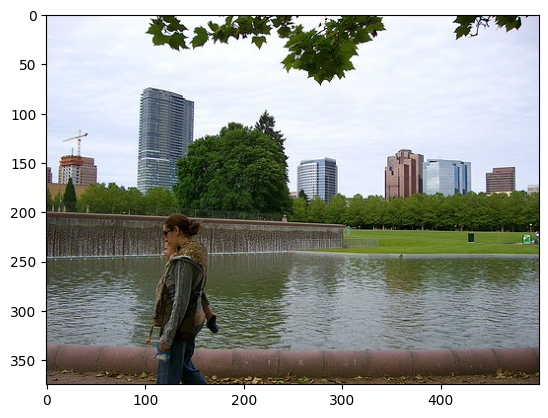

In [27]:
generate_caption_dataset('159712188_d530dd478c')

---------------------Actual---------------------
startseq girls fighting on karate competition endseq
startseq two girls are kicking each other in martial arts uniforms endseq
startseq two people are performing karate at tournament endseq
startseq two woman are doing karate endseq
startseq two women in their karate uniforms kick at one another endseq
--------------------Predicted--------------------
a man in a white shirt and black pants is on a white and black


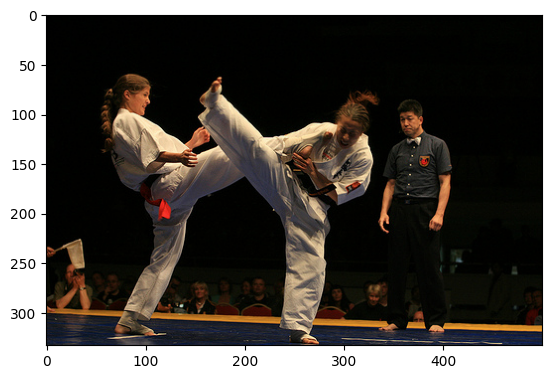

In [29]:
generate_caption_dataset('3697456750_460aea7252')

---------------------Actual---------------------
startseq man in pink shirt and white vest plays guitar endseq
startseq man in pink shirt playing guitar endseq
startseq man in white suit and pink shirt plays guitar endseq
startseq man wearing pants plays guitar while onstage endseq
startseq the man in the white and pink outfit is holding guitar endseq
--------------------Predicted--------------------
a man on a stage with a guitar


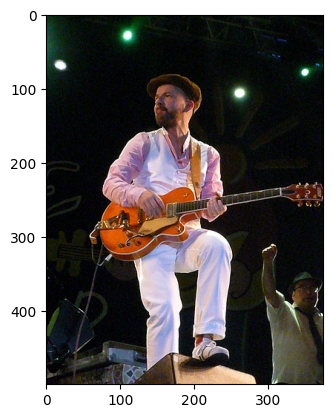

In [30]:
generate_caption_dataset('3723690961_729dd5d617')